## **Install Necessary Packages**
 - Always run this when starting the notebook

In [2]:
from netCDF4 import Dataset, num2date, date2num
import csv
import glob
import xarray as xr 
import seaborn as sns
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim, vertcross,
                 cartopy_ylim, interplevel, latlon_coords, uvmet, CoordPair,
                ALL_TIMES)
from matplotlib.dates import MonthLocator
import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import dask.array as da
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.ticker as mticker
from matplotlib.cm import get_cmap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
Saved_Data_Path =  r'/glade/u/home/mwarms/SavedData/'
SNOWIE_Data_Path = r'/glade/u/home/mwarms/SNOWIE_Seasonal_Data/wrfout_d02'
Scratch_Path = r'/glade/scratch/mwarms/temp/'

## **Load Event Indices & Projection Info**
- previously saved as CSVs

In [3]:
MonthlyLastTimestep = [0, 744, 1464, 2208, 2952, 3624, 4368, 5088]
Months = ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr"]

with open(Saved_Data_Path + 'EventLengths.csv') as f:
    reader = csv.reader(f)
    EventLengths = list(reader)
EventLengths = EventLengths[0]
EventLengths = [int(i) for i in EventLengths]

with open(Saved_Data_Path + 'EventTimesStart.csv') as f:
    reader = csv.reader(f)
    EventTimesStart = list(reader)
EventTimesStart = EventTimesStart[0]
EventTimesStart = [int(i) for i in EventTimesStart]

with open(Saved_Data_Path + 'EventTimesEnd.csv') as f:
    reader = csv.reader(f)
    EventTimesEnd = list(reader)
EventTimesEnd = EventTimesEnd[0]
EventTimesEnd = [int(i) for i in EventTimesEnd]

with open(Saved_Data_Path + 'SnowfallEventNumbered.csv') as f:
    reader = csv.reader(f)
    SnowfallEventNumbered = list(reader)
SnowfallEventNumbered = SnowfallEventNumbered[0]
SnowfallEventNumbered = [int(float(i)) for i in SnowfallEventNumbered]

with open(Saved_Data_Path + 'MonthlyEventIndices.csv') as f:
    reader = csv.reader(f)
    MonthlyEventIndices = list(reader)
MonthlyEventIndices = MonthlyEventIndices[0]
MonthlyEventIndices = [int(i) for i in MonthlyEventIndices]

**If Plotting Spatially, Load Projection**

In [4]:
dummy_file = Dataset(SNOWIE_Data_Path + '/wrfout_d02_2016-10-01_00:00:00')
cartopy_dom = getvar(dummy_file, "ter")
cart_proj_dom = get_cartopy(cartopy_dom)

lat_min = 43
lat_max = 46
lon_min = -117
lon_max = -111

mask_lon = (cartopy_dom.XLONG >= lon_min) & (cartopy_dom.XLONG <= lon_max)
mask_lat = (cartopy_dom.XLAT >= lat_min) & (cartopy_dom.XLAT <= lat_max)

cartopy_aoi = cartopy_dom.where(mask_lon & mask_lat, drop=True)
cart_proj_aoi = get_cartopy(cartopy_aoi)

del cartopy_dom, cart_proj_dom, mask_lon, mask_lat

## Load QVARs from Scratch

- **Load QCLOUD from Scratch**

In [3]:
# Scratch Paths for QCLOUD by month
Oct_Path =  r'/glade/scratch/mwarms/temp/QSNOW_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/QSNOW_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/QSNOW_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/QSNOW_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/QSNOW_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/QSNOW_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/QSNOW_snowie_apr.nc'

# Load QSNOWs
QSNOW_snowie_oct = xr.open_dataarray(Oct_Path)
QSNOW_snowie_nov = xr.open_dataarray(Nov_Path)
QSNOW_snowie_dec = xr.open_dataarray(Dec_Path)
QSNOW_snowie_jan = xr.open_dataarray(Jan_Path)
QSNOW_snowie_feb = xr.open_dataarray(Feb_Path)
QSNOW_snowie_mar = xr.open_dataarray(Mar_Path)
QSNOW_snowie_apr = xr.open_dataarray(Apr_Path)

- **Load QCLOUD from Scratch**

In [3]:
# Scratch Paths for QCLOUD by month
Oct_Path =  r'/glade/scratch/mwarms/temp/QCLOUD_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/QCLOUD_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/QCLOUD_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/QCLOUD_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/QCLOUD_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/QCLOUD_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/QCLOUD_snowie_apr.nc'

# Load QCLOUDs
QCLOUD_snowie_oct = xr.open_dataarray(Oct_Path)
QCLOUD_snowie_nov = xr.open_dataarray(Nov_Path)
QCLOUD_snowie_dec = xr.open_dataarray(Dec_Path)
QCLOUD_snowie_jan = xr.open_dataarray(Jan_Path)
QCLOUD_snowie_feb = xr.open_dataarray(Feb_Path)
QCLOUD_snowie_mar = xr.open_dataarray(Mar_Path)
QCLOUD_snowie_apr = xr.open_dataarray(Apr_Path)

- **Load CLDFRA from Scratch**

In [5]:
# Scratch Paths for CLDFRA by month
Oct_Path =  r'/glade/scratch/mwarms/temp/CLDFRA_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/CLDFRA_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/CLDFRA_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/CLDFRA_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/CLDFRA_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/CLDFRA_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/CLDFRA_snowie_apr.nc'

# Load CLDFRAs
CLDFRA_snowie_oct = xr.open_dataarray(Oct_Path)
CLDFRA_snowie_nov = xr.open_dataarray(Nov_Path)
CLDFRA_snowie_dec = xr.open_dataarray(Dec_Path)
CLDFRA_snowie_jan = xr.open_dataarray(Jan_Path)
CLDFRA_snowie_feb = xr.open_dataarray(Feb_Path)
CLDFRA_snowie_mar = xr.open_dataarray(Mar_Path)
CLDFRA_snowie_apr = xr.open_dataarray(Apr_Path)

- **Load Z from Scratch**

In [3]:
# Scratch Paths for z by month
Oct_Path =  r'/glade/scratch/mwarms/temp/z_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/z_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/z_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/z_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/z_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/z_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/z_snowie_apr.nc'

# Load z
z_snowie_oct = xr.open_dataarray(Oct_Path)
z_snowie_nov = xr.open_dataarray(Nov_Path)
z_snowie_dec = xr.open_dataarray(Dec_Path)
z_snowie_jan = xr.open_dataarray(Jan_Path)
z_snowie_feb = xr.open_dataarray(Feb_Path)
z_snowie_mar = xr.open_dataarray(Mar_Path)
z_snowie_apr = xr.open_dataarray(Apr_Path)

- **Load QGRAUP from Scratch**

In [3]:
# Scratch Paths for QGRAUP by month
Oct_Path =  r'/glade/scratch/mwarms/temp/QGRAUP_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/QGRAUP_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/QGRAUP_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/QGRAUP_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/QGRAUP_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/QGRAUP_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/QGRAUP_snowie_apr.nc'

# Load QGRAUP
QGRAUP_snowie_oct = xr.open_dataarray(Oct_Path)
QGRAUP_snowie_nov = xr.open_dataarray(Nov_Path)
QGRAUP_snowie_dec = xr.open_dataarray(Dec_Path)
QGRAUP_snowie_jan = xr.open_dataarray(Jan_Path)
QGRAUP_snowie_feb = xr.open_dataarray(Feb_Path)
QGRAUP_snowie_mar = xr.open_dataarray(Mar_Path)
QGRAUP_snowie_apr = xr.open_dataarray(Apr_Path)

## Monthly Averaged Statistics for all QVARs

- **QSNOW Statistics**

In [ ]:
QSNOW_snowie_oct_dailymean = QSNOW_snowie_oct.resample(Time='1M').mean()
QSNOW_snowie_oct_dailymean = QSNOW_snowie_oct_dailymean.mean(dim='bottom_top')

In [35]:
QSNOW_snowie_nov_dailymean = QSNOW_snowie_nov.resample(Time='1M').mean()
QSNOW_snowie_nov_dailymean = QSNOW_snowie_nov_dailymean.mean(dim='bottom_top')

In [37]:
QSNOW_snowie_dec_dailymean = QSNOW_snowie_dec.resample(Time='1M').mean()
QSNOW_snowie_dec_dailymean = QSNOW_snowie_dec_dailymean.mean(dim='bottom_top')

In [39]:
QSNOW_snowie_jan_dailymean = QSNOW_snowie_jan.resample(Time='1M').mean()
QSNOW_snowie_jan_dailymean = QSNOW_snowie_jan_dailymean.mean(dim='bottom_top')

In [41]:
QSNOW_snowie_feb_dailymean = QSNOW_snowie_feb.resample(Time='1M').mean()
QSNOW_snowie_feb_dailymean = QSNOW_snowie_feb_dailymean.mean(dim='bottom_top')

In [43]:
QSNOW_snowie_mar_dailymean = QSNOW_snowie_mar.resample(Time='1M').mean()
QSNOW_snowie_mar_dailymean = QSNOW_snowie_mar_dailymean.mean(dim='bottom_top')

In [45]:
QSNOW_snowie_apr_dailymean = QSNOW_snowie_apr.resample(Time='1M').mean()
QSNOW_snowie_apr_dailymean = QSNOW_snowie_apr_dailymean.mean(dim='bottom_top')

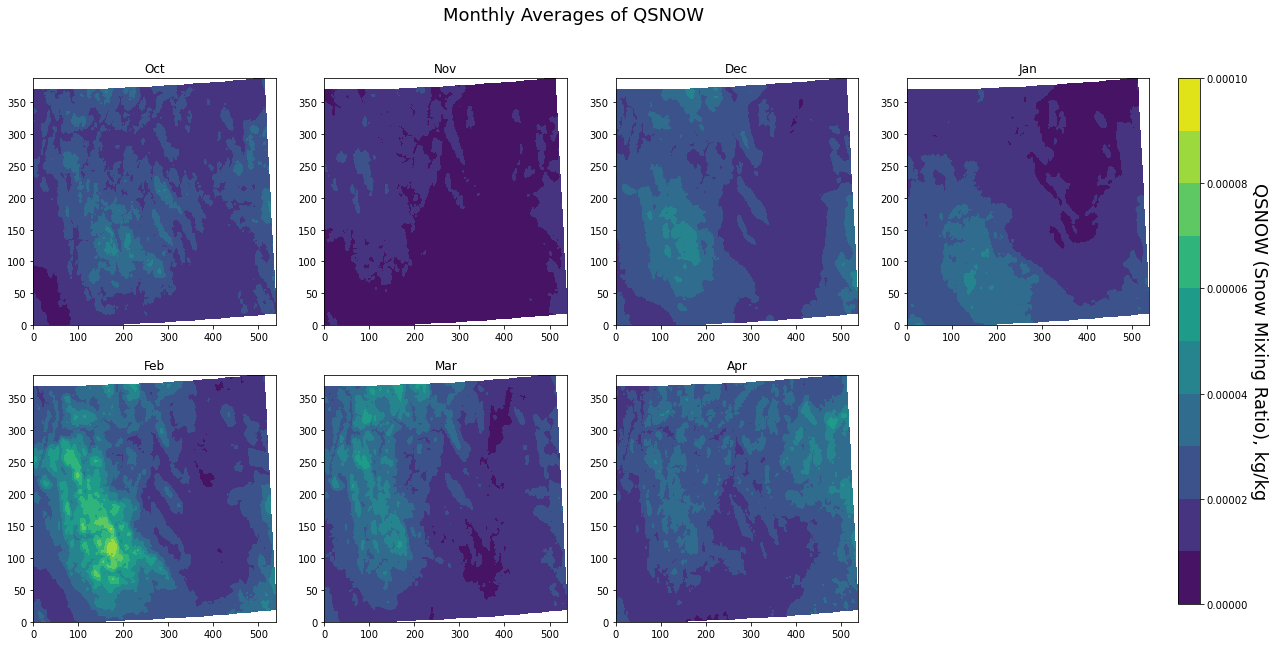

In [100]:
fig = plt.figure(figsize = [20,10])
ax1 = fig.add_subplot(2,4,1)
ax2 = fig.add_subplot(2,4,2)
ax3 = fig.add_subplot(2,4,3)
ax4 = fig.add_subplot(2,4,4)
ax5 = fig.add_subplot(2,4,5)
ax6 = fig.add_subplot(2,4,6)
ax7 = fig.add_subplot(2,4,7)

contour_levels = [0, 0.00001, 0.00002, 0.00003, 0.00004, 0.00005, 0.00006, 0.00007, 0.00008, 0.00009, 0.0001] 

ax1f = ax1.contourf(QSNOW_snowie_oct_dailymean[0,:,:], contour_levels)
ax2.contourf(QSNOW_snowie_nov_dailymean[0,:,:], contour_levels)
ax3.contourf(QSNOW_snowie_dec_dailymean[0,:,:], contour_levels)
ax4.contourf(QSNOW_snowie_jan_dailymean[0,:,:], contour_levels)
ax5.contourf(QSNOW_snowie_feb_dailymean[0,:,:], contour_levels)
ax6.contourf(QSNOW_snowie_mar_dailymean[0,:,:], contour_levels)
ax7.contourf(QSNOW_snowie_apr_dailymean[0,:,:], contour_levels)

ax1.set_title('Oct')
ax2.set_title('Nov')
ax3.set_title('Dec')
ax4.set_title('Jan')
ax5.set_title('Feb')
ax6.set_title('Mar')
ax7.set_title('Apr')

cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.73])
cbar = plt.colorbar(ax1f, cax=cbar_ax)
cbar.set_label('QSNOW (Snow Mixing Ratio), kg/kg', rotation = 270, labelpad = 20, fontsize=18)

plt.suptitle("Monthly Averages of QSNOW", fontsize = 18)
plt.show()

- **Cloud Fraction Statistics**

In [16]:
CLDFRA_snowie_oct_dailymean = CLDFRA_snowie_oct.resample(Time='1M').mean()
CLDFRA_snowie_oct_dailymean = CLDFRA_snowie_oct_dailymean.mean(dim='bottom_top')

In [19]:
CLDFRA_snowie_nov_dailymean = CLDFRA_snowie_nov.resample(Time='1M').mean()
CLDFRA_snowie_nov_dailymean = CLDFRA_snowie_nov_dailymean.mean(dim='bottom_top')

In [21]:
CLDFRA_snowie_dec_dailymean = CLDFRA_snowie_dec.resample(Time='1M').mean()
CLDFRA_snowie_dec_dailymean = CLDFRA_snowie_dec_dailymean.mean(dim='bottom_top')

In [23]:
CLDFRA_snowie_jan_dailymean = CLDFRA_snowie_jan.resample(Time='1M').mean()
CLDFRA_snowie_jan_dailymean = CLDFRA_snowie_jan_dailymean.mean(dim='bottom_top')

In [25]:
CLDFRA_snowie_feb_dailymean = CLDFRA_snowie_feb.resample(Time='1M').mean()
CLDFRA_snowie_feb_dailymean = CLDFRA_snowie_feb_dailymean.mean(dim='bottom_top')

In [27]:
CLDFRA_snowie_mar_dailymean = CLDFRA_snowie_mar.resample(Time='1M').mean()
CLDFRA_snowie_mar_dailymean = CLDFRA_snowie_mar_dailymean.mean(dim='bottom_top')

In [29]:
CLDFRA_snowie_apr_dailymean = CLDFRA_snowie_apr.resample(Time='1M').mean()
CLDFRA_snowie_apr_dailymean = CLDFRA_snowie_apr_dailymean.mean(dim='bottom_top')

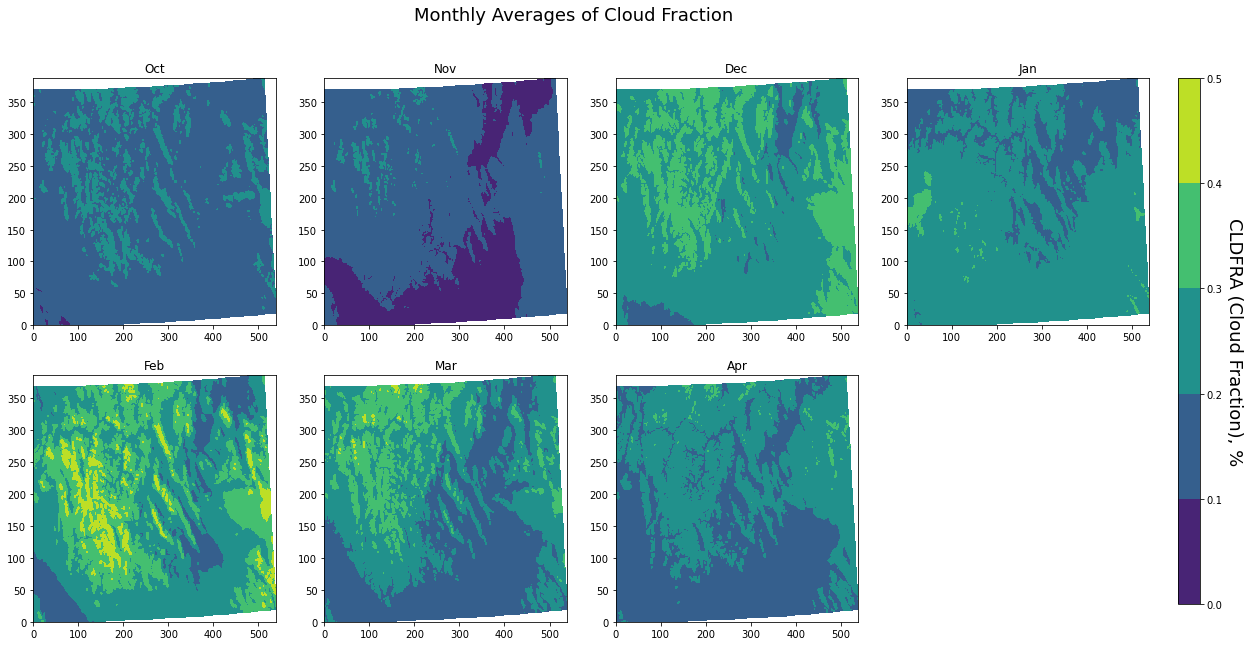

In [101]:
fig = plt.figure(figsize = [20,10])
ax1 = fig.add_subplot(2,4,1)
ax2 = fig.add_subplot(2,4,2)
ax3 = fig.add_subplot(2,4,3)
ax4 = fig.add_subplot(2,4,4)
ax5 = fig.add_subplot(2,4,5)
ax6 = fig.add_subplot(2,4,6)
ax7 = fig.add_subplot(2,4,7)

contour_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5] 

ax1f = ax1.contourf(CLDFRA_snowie_oct_dailymean[0,:,:], contour_levels)
ax2.contourf(CLDFRA_snowie_nov_dailymean[0,:,:], contour_levels)
ax3.contourf(CLDFRA_snowie_dec_dailymean[0,:,:], contour_levels)
ax4.contourf(CLDFRA_snowie_jan_dailymean[0,:,:], contour_levels)
ax5.contourf(CLDFRA_snowie_feb_dailymean[0,:,:], contour_levels)
ax6.contourf(CLDFRA_snowie_mar_dailymean[0,:,:], contour_levels)
ax7.contourf(CLDFRA_snowie_apr_dailymean[0,:,:], contour_levels)

ax1.set_title('Oct')
ax2.set_title('Nov')
ax3.set_title('Dec')
ax4.set_title('Jan')
ax5.set_title('Feb')
ax6.set_title('Mar')
ax7.set_title('Apr')

cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.73])
cbar = plt.colorbar(ax1f, cax=cbar_ax)
cbar.set_label('CLDFRA (Cloud Fraction), %', rotation = 270, labelpad = 20, fontsize=18)

plt.suptitle("Monthly Averages of Cloud Fraction", fontsize = 18)
plt.show()

- **QCLOUD Statistics**

In [47]:
QCLOUD_snowie_oct_dailymean = QCLOUD_snowie_oct.resample(Time='1M').mean()
QCLOUD_snowie_oct_dailymean = QCLOUD_snowie_oct_dailymean.mean(dim='bottom_top')

In [49]:
QCLOUD_snowie_nov_dailymean = QCLOUD_snowie_nov.resample(Time='1M').mean()
QCLOUD_snowie_nov_dailymean = QCLOUD_snowie_nov_dailymean.mean(dim='bottom_top')

In [51]:
QCLOUD_snowie_dec_dailymean = QCLOUD_snowie_dec.resample(Time='1M').mean()
QCLOUD_snowie_dec_dailymean = QCLOUD_snowie_dec_dailymean.mean(dim='bottom_top')

In [53]:
QCLOUD_snowie_jan_dailymean = QCLOUD_snowie_jan.resample(Time='1M').mean()
QCLOUD_snowie_jan_dailymean = QCLOUD_snowie_jan_dailymean.mean(dim='bottom_top')

In [55]:
QCLOUD_snowie_feb_dailymean = QCLOUD_snowie_feb.resample(Time='1M').mean()
QCLOUD_snowie_feb_dailymean = QCLOUD_snowie_feb_dailymean.mean(dim='bottom_top')

In [57]:
QCLOUD_snowie_mar_dailymean = QCLOUD_snowie_mar.resample(Time='1M').mean()
QCLOUD_snowie_mar_dailymean = QCLOUD_snowie_mar_dailymean.mean(dim='bottom_top')

In [59]:
QCLOUD_snowie_apr_dailymean = QCLOUD_snowie_apr.resample(Time='1M').mean()
QCLOUD_snowie_apr_dailymean = QCLOUD_snowie_apr_dailymean.mean(dim='bottom_top')

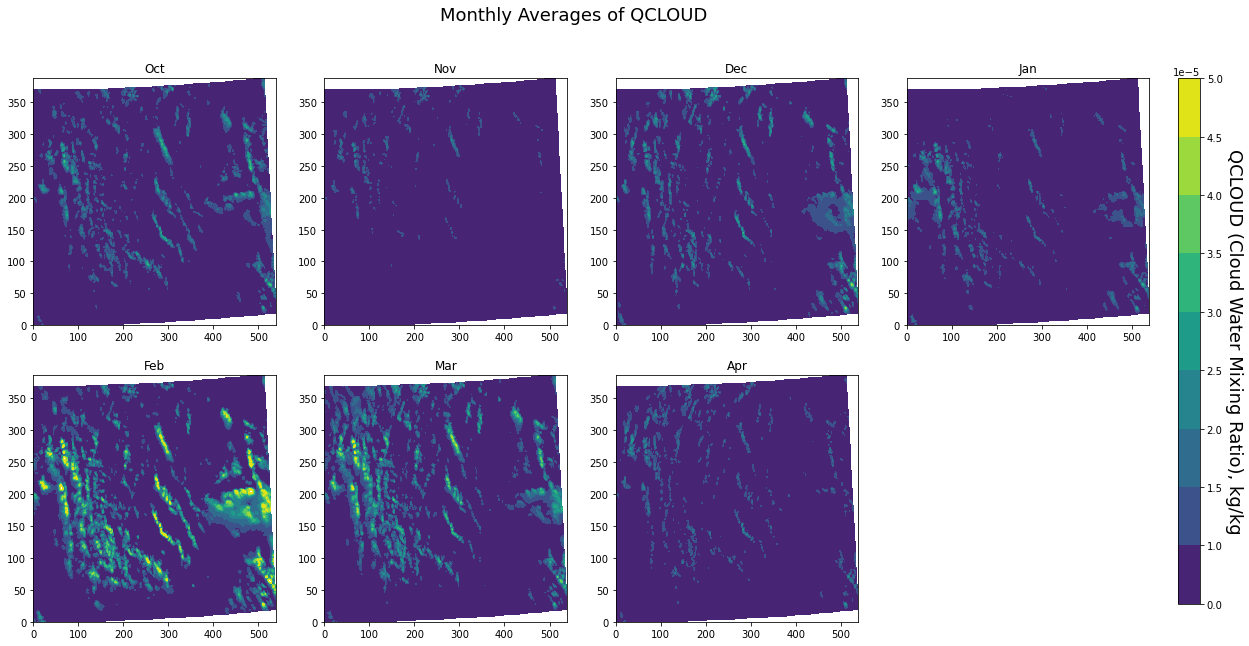

In [105]:
fig = plt.figure(figsize = [20,10])
ax1 = fig.add_subplot(2,4,1)
ax2 = fig.add_subplot(2,4,2)
ax3 = fig.add_subplot(2,4,3)
ax4 = fig.add_subplot(2,4,4)
ax5 = fig.add_subplot(2,4,5)
ax6 = fig.add_subplot(2,4,6)
ax7 = fig.add_subplot(2,4,7)

contour_levels = [0, 0.00001, 0.000015, 0.00002, 0.000025, 0.00003, 0.000035, 0.00004, 0.000045, 0.00005]

ax1f = ax1.contourf(QCLOUD_snowie_oct_dailymean[0,:,:], contour_levels)
ax2.contourf(QCLOUD_snowie_nov_dailymean[0,:,:], contour_levels)
ax3.contourf(QCLOUD_snowie_dec_dailymean[0,:,:], contour_levels)
ax4.contourf(QCLOUD_snowie_jan_dailymean[0,:,:], contour_levels)
ax5.contourf(QCLOUD_snowie_feb_dailymean[0,:,:], contour_levels)
ax6.contourf(QCLOUD_snowie_mar_dailymean[0,:,:], contour_levels)
ax7.contourf(QCLOUD_snowie_apr_dailymean[0,:,:], contour_levels)

ax1.set_title('Oct')
ax2.set_title('Nov')
ax3.set_title('Dec')
ax4.set_title('Jan')
ax5.set_title('Feb')
ax6.set_title('Mar')
ax7.set_title('Apr')

cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.73])
cbar = plt.colorbar(ax1f, cax=cbar_ax)
cbar.set_label('QCLOUD (Cloud Water Mixing Ratio), kg/kg', rotation = 270, labelpad = 20, fontsize=18)

plt.suptitle("Monthly Averages of QCLOUD", fontsize = 18)
plt.show()

## QGRAUP Statistics

In [4]:
QGRAUP_snowie_oct_chunked = QGRAUP_snowie_oct.chunk({'Time':24, "bottom_top":1})
QGRAUP_snowie_nov_chunked = QGRAUP_snowie_nov.chunk({'Time':24, "bottom_top":1})
QGRAUP_snowie_dec_chunked = QGRAUP_snowie_dec.chunk({'Time':24, "bottom_top":1})
QGRAUP_snowie_jan_chunked = QGRAUP_snowie_jan.chunk({'Time':24, "bottom_top":1})
QGRAUP_snowie_feb_chunked = QGRAUP_snowie_feb.chunk({'Time':24, "bottom_top":1})
QGRAUP_snowie_mar_chunked = QGRAUP_snowie_mar.chunk({'Time':24, "bottom_top":1})
QGRAUP_snowie_apr_chunked = QGRAUP_snowie_apr.chunk({'Time':24, "bottom_top":1})

In [5]:
QGRAUP_snowie_oct_dailymean = QGRAUP_snowie_oct_chunked.resample(Time='1M').mean().mean(dim='bottom_top').compute()

In [6]:
QGRAUP_snowie_nov_dailymean = QGRAUP_snowie_nov_chunked.resample(Time='1M').mean().mean(dim='bottom_top').compute()

In [7]:
QGRAUP_snowie_dec_dailymean = QGRAUP_snowie_dec_chunked.resample(Time='1M').mean().mean(dim='bottom_top').compute()

In [8]:
QGRAUP_snowie_jan_dailymean = QGRAUP_snowie_jan_chunked.resample(Time='1M').mean().mean(dim='bottom_top').compute()

In [9]:
QGRAUP_snowie_feb_dailymean = QGRAUP_snowie_feb_chunked.resample(Time='1M').mean().mean(dim='bottom_top').compute()

In [10]:
QGRAUP_snowie_mar_dailymean = QGRAUP_snowie_mar_chunked.resample(Time='1M').mean().mean(dim='bottom_top').compute()

In [11]:
QGRAUP_snowie_apr_dailymean = QGRAUP_snowie_apr_chunked.resample(Time='1M').mean().mean(dim='bottom_top').compute()

In [12]:
QGRAUP_snowie_oct_dailymean.max(), QGRAUP_snowie_nov_dailymean.max(), QGRAUP_snowie_dec_dailymean.max(), QGRAUP_snowie_jan_dailymean.max(), QGRAUP_snowie_feb_dailymean.max(), QGRAUP_snowie_mar_dailymean.max(),  QGRAUP_snowie_apr_dailymean.max() 

(<xarray.DataArray 'QGRAUP' ()>
 array(6.71896987e-06),
 <xarray.DataArray 'QGRAUP' ()>
 array(2.27427017e-06),
 <xarray.DataArray 'QGRAUP' ()>
 array(3.15964417e-06),
 <xarray.DataArray 'QGRAUP' ()>
 array(2.75983325e-06),
 <xarray.DataArray 'QGRAUP' ()>
 array(8.73679528e-06),
 <xarray.DataArray 'QGRAUP' ()>
 array(7.67441998e-06),
 <xarray.DataArray 'QGRAUP' ()>
 array(4.70465056e-06))

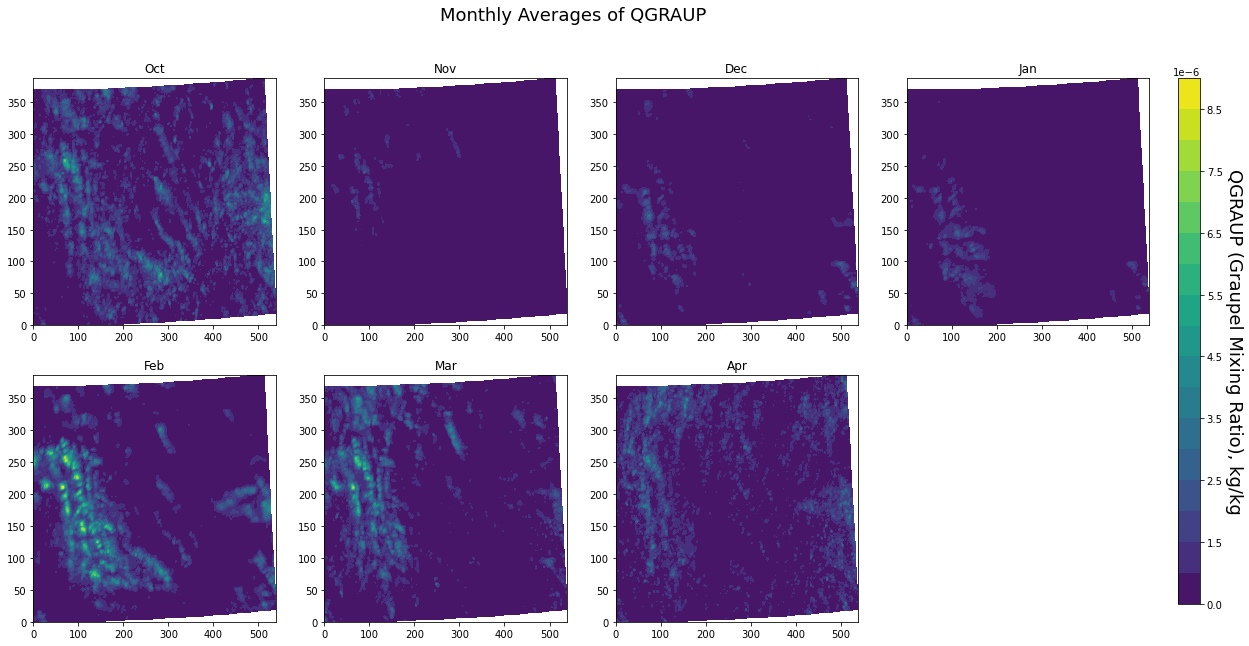

In [13]:
fig = plt.figure(figsize = [20,10])
ax1 = fig.add_subplot(2,4,1)
ax2 = fig.add_subplot(2,4,2)
ax3 = fig.add_subplot(2,4,3)
ax4 = fig.add_subplot(2,4,4)
ax5 = fig.add_subplot(2,4,5)
ax6 = fig.add_subplot(2,4,6)
ax7 = fig.add_subplot(2,4,7)

contour_levels = [0, 0.000001, 0.0000015, 0.000002, 0.0000025, 0.000003, 0.0000035, 0.000004, 0.0000045, 0.000005, 0.0000055, 0.000006, 0.0000065, 0.000007, 0.0000075, 0.0000080, 0.0000085, 0.000009]

ax1f = ax1.contourf(QGRAUP_snowie_oct_dailymean[0,:,:], contour_levels)
ax2.contourf(QGRAUP_snowie_nov_dailymean[0,:,:], contour_levels)
ax3.contourf(QGRAUP_snowie_dec_dailymean[0,:,:], contour_levels)
ax4.contourf(QGRAUP_snowie_jan_dailymean[0,:,:], contour_levels)
ax5.contourf(QGRAUP_snowie_feb_dailymean[0,:,:], contour_levels)
ax6.contourf(QGRAUP_snowie_mar_dailymean[0,:,:], contour_levels)
ax7.contourf(QGRAUP_snowie_apr_dailymean[0,:,:], contour_levels)

ax1.set_title('Oct')
ax2.set_title('Nov')
ax3.set_title('Dec')
ax4.set_title('Jan')
ax5.set_title('Feb')
ax6.set_title('Mar')
ax7.set_title('Apr')

cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.73])
cbar = plt.colorbar(ax1f, cax=cbar_ax)
cbar.set_label('QGRAUP (Graupel Mixing Ratio), kg/kg', rotation = 270, labelpad = 20, fontsize=18)

plt.suptitle("Monthly Averages of QGRAUP", fontsize = 18)
plt.show()

## CFADs of QGRAUP

In [4]:
QGRAUP_bins = np.arange(0, 0.00001, .000001)

In [5]:
# z_bins = z_snowie_oct.mean(dim='Time').mean(dim='south_north').mean(dim='west_east')
# np.savetxt(Saved_Data_Path + 'z_bins.csv', z_bins, delimiter=",")
z_bins = np.genfromtxt(Saved_Data_Path + 'z_bins.csv', delimiter = ",")

In [9]:
range(0,len(z_bins)), range(0,len(QGRAUP_bins))

(range(0, 80), range(0, 11))

In [6]:
QGRAUP_bins_count_oct = np.zeros([len(QGRAUP_bins), len(z_bins)])
QGRAUP_bins_count_nov = np.zeros([len(QGRAUP_bins), len(z_bins)])
QGRAUP_bins_count_dec = np.zeros([len(QGRAUP_bins), len(z_bins)])
QGRAUP_bins_count_jan = np.zeros([len(QGRAUP_bins), len(z_bins)])
QGRAUP_bins_count_feb = np.zeros([len(QGRAUP_bins), len(z_bins)])
QGRAUP_bins_count_mar = np.zeros([len(QGRAUP_bins), len(z_bins)])
QGRAUP_bins_count_apr = np.zeros([len(QGRAUP_bins), len(z_bins)])

In [7]:
QGRAUP_bins_count_oct.shape

(11, 80)

In [7]:
QGRAUP_snowie_oct_chunked = QGRAUP_snowie_oct.chunk({'Time':24, "bottom_top":1})
QGRAUP_snowie_nov_chunked = QGRAUP_snowie_nov.chunk({'Time':24, "bottom_top":1})
QGRAUP_snowie_dec_chunked = QGRAUP_snowie_dec.chunk({'Time':24, "bottom_top":1})
QGRAUP_snowie_jan_chunked = QGRAUP_snowie_jan.chunk({'Time':24, "bottom_top":1})
QGRAUP_snowie_feb_chunked = QGRAUP_snowie_feb.chunk({'Time':24, "bottom_top":1})
QGRAUP_snowie_mar_chunked = QGRAUP_snowie_mar.chunk({'Time':24, "bottom_top":1})
QGRAUP_snowie_apr_chunked = QGRAUP_snowie_apr.chunk({'Time':24, "bottom_top":1})

In [10]:
for i in range(0,len(z_bins)):                          # vertical bins
    for j in range(0,len(QGRAUP_bins)):                 # QGRAUP bins
        for k in range(0,len(QGRAUP_snowie_oct)):       # Timesteps
            if j == 0:
                QGRAUP_bins_count_oct[j,i] += QGRAUP_snowie_oct_chunked[k, i, :, :].where(QGRAUP_snowie_oct_chunked[k,i,:,:] <= QGRAUP_bins[j]).count().compute()
            else:
                if k == 350:
                    print(i,j)
                QGRAUP_bins_count_oct[j,i] += QGRAUP_snowie_oct_chunked[k, i, :, :].where(QGRAUP_snowie_oct_chunked[k,i,:,:] <= QGRAUP_bins[j]).where(QGRAUP_snowie_oct_chunked[k,i,:,:] > QGRAUP_bins[j-1]).count().compute()

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
21 1
21 2
21 3
21 4
21 5
21 6
21 7
21 8
21 9
22 1
22 2
22 3
22 4
22 5
22 6
22 7
22 8
22 9
23 1
23 2
23 3
23 4
23 5
23 6
23 7
23 8
23 9
24 1
24 2


In [11]:
np.savetxt(Saved_Data_Path + 'QGRAUP_bins_count_oct.csv', QGRAUP_bins_count_oct, delimiter=",")

In [8]:
for i in range(0,len(z_bins)):                          # vertical bins
    for j in range(0,len(QGRAUP_bins)):                 # QGRAUP bins
        for k in range(0,len(QGRAUP_snowie_nov)):       # Timesteps
            if j == 0:
                QGRAUP_bins_count_nov[j,i] += QGRAUP_snowie_nov_chunked[k, i, :, :].where(QGRAUP_snowie_nov_chunked[k,i,:,:] <= QGRAUP_bins[j]).count().compute()
            else:
                if k == 350:
                    print(i,j)                
                QGRAUP_bins_count_nov[j,i] += QGRAUP_snowie_nov_chunked[k, i, :, :].where(QGRAUP_snowie_nov_chunked[k,i,:,:] <= QGRAUP_bins[j]).where(QGRAUP_snowie_nov_chunked[k,i,:,:] > QGRAUP_bins[j-1]).count().compute()

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
16 10
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
18 10
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
19 10
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
20 10
21 1
21 2
21 3
21 4
21 5
21 6

In [9]:
np.savetxt(Saved_Data_Path + 'QGRAUP_bins_count_nov.csv', QGRAUP_bins_count_nov, delimiter=",")

In [10]:
for i in range(0,len(z_bins)):                          # vertical bins
    for j in range(0,len(QGRAUP_bins)):                 # CLDFRA bins
        for k in range(0,len(QGRAUP_snowie_dec)):       # Timesteps
            if j == 0:
                QGRAUP_bins_count_dec[j,i] += QGRAUP_snowie_dec_chunked[k, i, :, :].where(QGRAUP_snowie_dec_chunked[k,i,:,:] <= QGRAUP_bins[j]).count().compute()
            else:
                if k == 350:
                    print(i,j)
                QGRAUP_bins_count_dec[j,i] += QGRAUP_snowie_dec_chunked[k, i, :, :].where(QGRAUP_snowie_dec_chunked[k,i,:,:] <= QGRAUP_bins[j]).where(QGRAUP_snowie_dec_chunked[k,i,:,:] > QGRAUP_bins[j-1]).count().compute()

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
16 10
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
18 10
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
19 10
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
20 10
21 1
21 2
21 3
21 4
21 5
21 6

In [11]:
np.savetxt(Saved_Data_Path + 'QGRAUP_bins_count_dec.csv', QGRAUP_bins_count_dec, delimiter=",")

In [12]:
for i in range(0,len(z_bins)):                          # vertical bins
    for j in range(0,len(QGRAUP_bins)):                 # CLDFRA bins
        for k in range(0,len(QGRAUP_snowie_jan)):       # Timesteps
            if j == 0:
                QGRAUP_bins_count_jan[j,i] += QGRAUP_snowie_jan_chunked[k, i, :, :].where(QGRAUP_snowie_jan_chunked[k,i,:,:] <= QGRAUP_bins[j]).count().compute()
            else:
                if k == 350:
                    print(i,j)
                QGRAUP_bins_count_jan[j,i] += QGRAUP_snowie_jan_chunked[k, i, :, :].where(QGRAUP_snowie_jan_chunked[k,i,:,:] <= QGRAUP_bins[j]).where(QGRAUP_snowie_jan_chunked[k,i,:,:] > QGRAUP_bins[j-1]).count().compute()

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
16 10
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
18 10
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
19 10
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
20 10
21 1
21 2
21 3
21 4
21 5
21 6

In [13]:
np.savetxt(Saved_Data_Path + 'QGRAUP_bins_count_jan.csv', QGRAUP_bins_count_jan, delimiter=",")

In [14]:
for i in range(0,len(z_bins)):                          # vertical bins
    for j in range(0,len(QGRAUP_bins)):                 # CLDFRA bins
        for k in range(0,len(QGRAUP_snowie_feb)):       # Timesteps
            if j == 0:
                QGRAUP_bins_count_feb[j,i] += QGRAUP_snowie_feb_chunked[k, i, :, :].where(QGRAUP_snowie_feb_chunked[k,i,:,:] <= QGRAUP_bins[j]).count().compute()
            else:
                if k == 350:
                    print(i,j)
                QGRAUP_bins_count_feb[j,i] += QGRAUP_snowie_feb_chunked[k, i, :, :].where(QGRAUP_snowie_feb_chunked[k,i,:,:] <= QGRAUP_bins[j]).where(QGRAUP_snowie_feb_chunked[k,i,:,:] > QGRAUP_bins[j-1]).count().compute()

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
16 10
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
18 10
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
19 10
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
20 10
21 1
21 2
21 3
21 4
21 5
21 6

In [15]:
np.savetxt(Saved_Data_Path + 'QGRAUP_bins_count_feb.csv', QGRAUP_bins_count_feb, delimiter=",")

In [16]:
for i in range(0,len(z_bins)):                          # vertical bins
    for j in range(0,len(QGRAUP_bins)):                 # CLDFRA bins
        for k in range(0,len(QGRAUP_snowie_mar)):       # Timesteps
            if j == 0:
                QGRAUP_bins_count_mar[j,i] += QGRAUP_snowie_mar_chunked[k, i, :, :].where(QGRAUP_snowie_mar_chunked[k,i,:,:] <= QGRAUP_bins[j]).count().compute()
            else:
                if k == 350:
                    print(i,j)
                QGRAUP_bins_count_mar[j,i] += QGRAUP_snowie_mar_chunked[k, i, :, :].where(QGRAUP_snowie_mar_chunked[k,i,:,:] <= QGRAUP_bins[j]).where(QGRAUP_snowie_mar_chunked[k,i,:,:] > QGRAUP_bins[j-1]).count().compute()

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
16 10
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
18 10
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
19 10
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
20 10
21 1
21 2
21 3
21 4
21 5
21 6

In [17]:
np.savetxt(Saved_Data_Path + 'QGRAUP_bins_count_mar.csv', QGRAUP_bins_count_mar, delimiter=",")

In [18]:
for i in range(0,len(z_bins)):                          # vertical bins
    for j in range(0,len(QGRAUP_bins)):                 # CLDFRA bins
        for k in range(0,len(QGRAUP_snowie_apr)):       # Timesteps
            if j == 0:
                QGRAUP_bins_count_apr[j,i] += QGRAUP_snowie_apr_chunked[k, i, :, :].where(QGRAUP_snowie_apr_chunked[k,i,:,:] <= QGRAUP_bins[j]).count().compute()
            else:
                if k == 350:
                    print(i,j)
                QGRAUP_bins_count_apr[j,i] += QGRAUP_snowie_apr_chunked[k, i, :, :].where(QGRAUP_snowie_apr_chunked[k,i,:,:] <= QGRAUP_bins[j]).where(QGRAUP_snowie_apr_chunked[k,i,:,:] > QGRAUP_bins[j-1]).count().compute()

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
16 10
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
18 10
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
19 10
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
20 10
21 1
21 2
21 3
21 4
21 5
21 6

In [19]:
np.savetxt(Saved_Data_Path + 'QGRAUP_bins_count_apr.csv', QGRAUP_bins_count_apr, delimiter=",")

## Load Cloud Fraction Bins from CSV

In [46]:
# QCLOUD_bins_count_oct = np.genfromtxt(Saved_Data_Path + 'QCLOUD_bins_count_oct.csv', delimiter = ",")
# QCLOUD_bins_count_nov = np.genfromtxt(Saved_Data_Path + 'QCLOUD_bins_count_nov.csv', delimiter = ",")
# QCLOUD_bins_count_dec = np.genfromtxt(Saved_Data_Path + 'QCLOUD_bins_count_dec.csv', delimiter = ",")
# QCLOUD_bins_count_jan = np.genfromtxt(Saved_Data_Path + 'QCLOUD_bins_count_jan.csv', delimiter = ",")
# QCLOUD_bins_count_feb = np.genfromtxt(Saved_Data_Path + 'QCLOUD_bins_count_feb.csv', delimiter = ",")
# QCLOUD_bins_count_mar = np.genfromtxt(Saved_Data_Path + 'QCLOUD_bins_count_mar.csv', delimiter = ",")
# QCLOUD_bins_count_apr = np.genfromtxt(Saved_Data_Path + 'QCLOUD_bins_count_apr.csv', delimiter = ",")

In [ ]:
CountNans1 = QCLOUD_snowie_oct[0,:,:,:].isnull().count() - QCLOUD_snowie_oct[0,:,:,:].count()
CountNans2 = QCLOUD_snowie_oct[100,:,:,:].isnull().count() - QCLOUD_snowie_oct[100,:,:,:].count()
CountNans3 = QCLOUD_snowie_oct[200,:,:,:].isnull().count() - QCLOUD_snowie_oct[200,:,:,:].count()

CountNans1, CountNans2, CountNans3, 14508*744

In [ ]:
fig = plt.figure(figsize=(8,6)) 
# cb = fig.colorbar(WV_contours, ax=ax, shrink = 0.6) #(WV_Z_plot_array, shrink = 0.6)
# ax = plt.subplot()
plt.pcolormesh(WV_bins, z_bins_WV, WV_Z_plot_array_normalized*100)
plt.title("CFAD - QVAPOR (water vapor mixing ratio)", fontsize = 16)
plt.ylabel("Height Above Terrain (m)", fontsize = 14)
plt.xlabel("QVAPOR (kg/kg)", fontsize = 14)
cbar = plt.colorbar()
cbar.set_label(label = "Normalized Frequency, %", fontsize = 14)